In [9]:
import torch
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from csibert_util import CSIBERT  # Your CSIBERT implementation
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns

import os
from pdf2image import convert_from_path
from PIL import Image

import time

W0920 13:59:25.132000 82005 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [28]:
# Load CSI data
cell_data = scipy.io.loadmat('foundation_model_data/csi_data_massive_mimo.mat')['multi_cell_csi']

# Preprocessing Function
def preprocess_csi_matrix(csi_matrix):
    csi_real = np.real(csi_matrix)
    csi_imag = np.imag(csi_matrix)
    csi_real_normalized = (csi_real - np.mean(csi_real)) / np.std(csi_real)
    csi_imag_normalized = (csi_imag - np.mean(csi_imag)) / np.std(csi_imag)
    csi_combined = np.stack([csi_real_normalized, csi_imag_normalized], axis=-1)
    time_dim = csi_combined.shape[0]
    feature_dim = np.prod(csi_combined.shape[1:])
    return csi_combined.reshape(time_dim, feature_dim)

# Process and Pad Data
preprocessed_data = []
sequence_lengths = []
for cell_idx in range(cell_data.shape[0]):
    for ue_idx in range(cell_data.shape[1]):
        ue_data = cell_data[cell_idx, ue_idx]
        for scenario in ue_data[0]:
            processed_csi = preprocess_csi_matrix(scenario)
            preprocessed_data.append(processed_csi)
            sequence_lengths.append(processed_csi.shape[0])

max_sequence_length = max(sequence_lengths)
feature_dim = preprocessed_data[0].shape[-1]

padded_data = np.zeros((len(preprocessed_data), max_sequence_length, feature_dim), dtype=np.float32)
attention_masks = np.zeros((len(preprocessed_data), max_sequence_length), dtype=np.float32)
for i, sequence in enumerate(preprocessed_data):
    seq_len = sequence.shape[0]
    padded_data[i, :seq_len, :] = sequence
    attention_masks[i, :seq_len] = 1  # Valid data mask


In [29]:
# Load the trained model
checkpoint_path = "checkpoints/best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
feature_dim = checkpoint["feature_dim"]

# Initialize CSIBERT model
model = CSIBERT(feature_dim=feature_dim)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Move the model to MPS
model.eval()
print("Model loaded successfully.")


Model loaded successfully.


---

# Reconstruction Error

In [30]:
# Prepare Dataset
masked_data = np.copy(padded_data)
masked_data[:, ::10, :] = 0  # Mask every 10th sample for evaluation

test_dataset = TensorDataset(
    torch.tensor(masked_data).float(),
    torch.tensor(padded_data).float()
)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluate Model
mse_errors = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
        mse_errors.append(mse)

# Average MSE
avg_mse = np.mean(mse_errors)
print(f"Reconstruction MSE: {avg_mse:.6f}")


Reconstruction MSE: 0.010990


# Experiment 2 - Scenario-wise Performance

In [6]:
# Compute MSE for each scenario
scenario_mse = []
scenario_names = ['Stationary', 'High-Speed', 'Urban Macro']

for scenario_idx in range(3):
    # Select every 3rd sample for each scenario
    scenario_data = masked_data[scenario_idx::3]
    labels = padded_data[scenario_idx::3]

    with torch.no_grad():
        # Ensure data is on the same device as the model
        inputs = torch.tensor(scenario_data).float().to(device)
        labels = torch.tensor(labels).float().to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute MSE
        mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
        scenario_mse.append(mse)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Scenario': scenario_names,
    'MSE': scenario_mse
})
results_df

,Scenario,MSE
0,Stationary,0.003184
1,High-Speed,0.003177
2,Urban Macro,0.026605


# Experiment 3 - Masking Ratio Sensitivity

In [7]:
# Function to apply masking to the data
def mask_data(data, mask_ratio=0.15):
    """
    Masks a random portion of the data for the masked signal prediction task.
    """
    mask = np.random.rand(*data.shape[:-1]) < mask_ratio  # Generate mask for all but the last dimension
    masked_data = np.copy(data)
    masked_data[mask, :] = 0  # Replace masked elements with 0
    return masked_data, mask


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/rh/1c0lrj_x0x956417g86lc4ph0000gn/T/ipykernel_60843/2193968771.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=results_df, x='Masking Ratio', y='MSE', ci='sd', err_style="band")


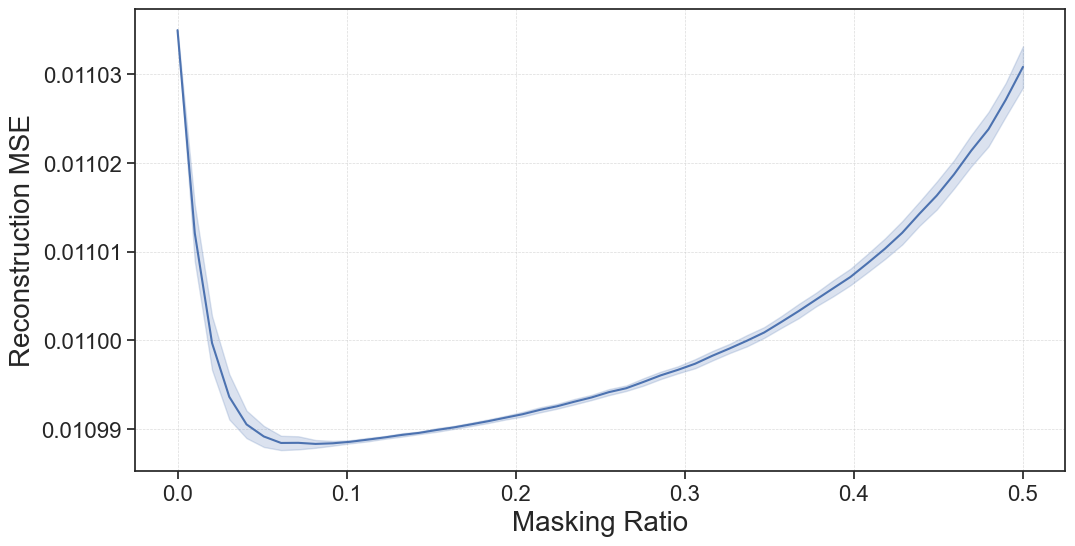

In [20]:
# Masking Ratios to Experiment With
mask_ratios = np.linspace(0.0, 0.5, 50)
num_trials = 100  # Number of times to repeat the experiment

# Prepare a DataFrame to store results
results = []

# Perform experiments
for trial in tqdm(range(num_trials), desc="Trials"):
    for ratio in mask_ratios:
        # Mask data with the current ratio
        masked_data, _ = mask_data(padded_data, mask_ratio=ratio)

        # Evaluate model performance
        with torch.no_grad():
            # Move tensors to the same device as the model
            inputs = torch.tensor(masked_data).float().to(device)
            labels = torch.tensor(padded_data).float().to(device)
            
            # Ensure model is on the same device
            model.to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute MSE
            mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())

        # Store the result
        results.append({'Masking Ratio': ratio, 'MSE': mse, 'Trial': trial})

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("ticks")  # Use a clean style with ticks

sns.lineplot(data=results_df, x='Masking Ratio', y='MSE', ci='sd', err_style="band")
plt.xlabel("Masking Ratio", fontsize=20)
plt.ylabel("Reconstruction MSE", fontsize=20)
#plt.title("Effect of Masking Ratio on Reconstruction (20 Trials)")
sns.set_style("ticks")
# Enable gridlines explicitly using Matplotlib
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/masking_ratio_vs_mse.pdf", dpi=300, bbox_inches='tight')

plt.show()


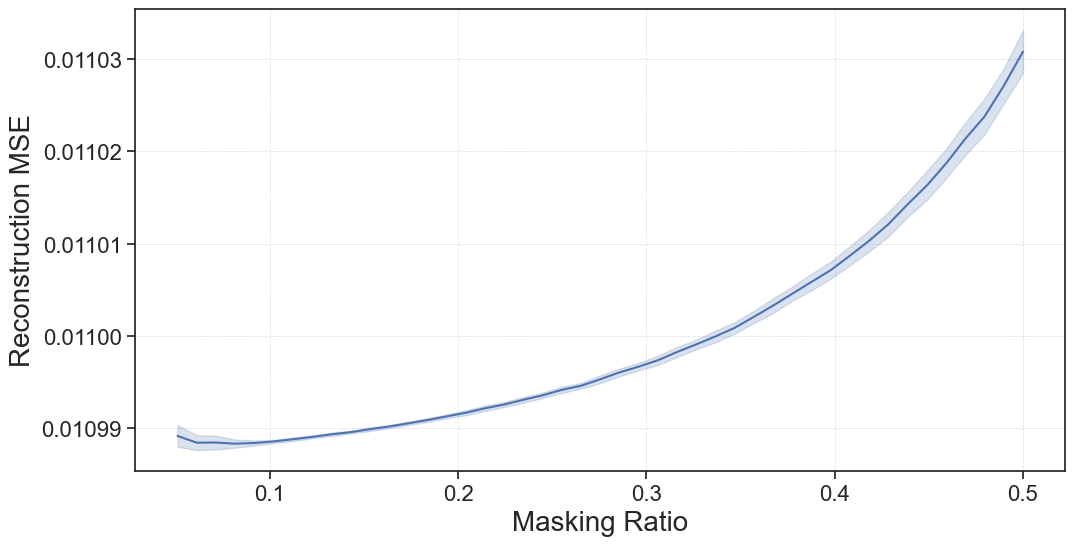

In [32]:
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("ticks")  # Use a clean style with ticks

subset_df = results_df[results_df["Masking Ratio"] > 0.05]

sns.lineplot(data=subset_df, x='Masking Ratio', y='MSE', errorbar='sd', err_style="band")
plt.xlabel("Masking Ratio", fontsize=20)
plt.ylabel("Reconstruction MSE", fontsize=20)
#plt.title("Effect of Masking Ratio on Reconstruction (20 Trials)")
sns.set_style("ticks")
# Enable gridlines explicitly using Matplotlib
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/masking_ratio_vs_mse.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [25]:
results_df.iloc[15:]

,Masking Ratio,MSE,Trial
15,0.153061,0.010990,0
16,0.163265,0.010990,0
17,0.173469,0.010990,0
18,0.183673,0.010991,0
19,0.193878,0.010991,0
...,...,...,...
4995,0.459184,0.011020,99
4996,0.469388,0.011021,99
4997,0.479592,0.011022,99
4998,0.489796,0.011028,99


# Experiment 4 - Attention Visualization

In [9]:
# Create directory to save images if it doesn't exist
output_dir = "imgs"
os.makedirs(output_dir, exist_ok=True)

# Perform the experiment 10 times
num_experiments = 10
for experiment in range(1, num_experiments + 1):
    # Randomly select a sample index
    sample_idx = np.random.randint(0, len(padded_data) - 1)
    
    # Extract sample input and attention mask
    sample_input = padded_data[sample_idx:sample_idx + 1]
    attention_mask = attention_masks[sample_idx:sample_idx + 1]

    # Convert to tensor and move to device
    sample_input_tensor = torch.tensor(sample_input).float().to(device)
    attention_mask_tensor = torch.tensor(attention_mask).float().to(device)

    # Get predictions and attention weights
    with torch.no_grad():
        predictions, attentions = model(sample_input_tensor, attention_mask_tensor, output_attentions=True)

    # Visualize attention for a specific layer and head
    layer_idx = 11  # Last layer
    head_idx = 0    # First head

    attention_weights = attentions[layer_idx][0, head_idx].cpu().numpy()  # Shape: (sequence_length, sequence_length)

    # Plot heatmap
    plt.figure(figsize=(9, 7))
    sns.heatmap(attention_weights, cmap="viridis", square=True)
    plt.xlabel("Input Sequence", fontsize=25)
    plt.ylabel("Output Sequence", fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=19)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=19)  # Minor ticks (if any)

    # Save the image
    output_path = os.path.join(output_dir, f"attention_visualization_experiment_{experiment}.pdf")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Experiment {experiment}: Visualization saved to {output_path}")

print("All attention visualizations saved.")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Experiment 1: Visualization saved to imgs/attention_visualization_experiment_1.pdf
Experiment 2: Visualization saved to imgs/attention_visualization_experiment_2.pdf
Experiment 3: Visualization saved to imgs/attention_visualization_experiment_3.pdf
Experiment 4: Visualization saved to imgs/attention_visualization_experiment_4.pdf
Experiment 5: Visualization saved to imgs/attention_visualization_experiment_5.pdf
Experiment 6: Visualization saved to imgs/attention_visualization_experiment_6.pdf
Experiment 7: Visualization saved to imgs/attention_visualization_experiment_7.pdf
Experiment 8: Visualization saved to imgs/attention_visualization_experiment_8.pdf
Experiment 9: Visualization saved to imgs/attention_visualization_experiment_9.pdf
Experiment 10: Visualization saved to imgs/attention_visualization_experiment_10.pdf
All attention visualizations saved.


# Experiment 5 - Performance Across Subcarriers

In [10]:
# Divide subcarriers into smaller groups for detailed analysis
subcarrier_groups = [(i, i + 7) for i in range(0, 64, 8)]  # 8 subcarriers per group

In [11]:
from sklearn.metrics import mean_squared_error

# Ensure model is on the same device as inputs
model.to(device)

# Initialize lists to store metrics
subcarrier_mse = []
subcarrier_std = []
subcarrier_max_error = []

for group in subcarrier_groups:
    group_data = padded_data[:, group[0]:group[1] + 1, :]  # Select subcarriers in the range
    masked_group_data, _ = mask_data(group_data, mask_ratio=0.15)

    errors = []
    with torch.no_grad():
        # Move inputs and labels to the same device as the model
        inputs = torch.tensor(masked_group_data).float().to(device)
        labels = torch.tensor(group_data).float().to(device)
        
        # Forward pass
        outputs = model(inputs)

        # Compute errors
        error = labels.cpu().numpy().flatten() - outputs.cpu().numpy().flatten()
        errors.extend(error)

    # Calculate metrics
    mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
    std = np.std(errors)
    max_error = np.max(np.abs(errors))

    subcarrier_mse.append(mse)
    subcarrier_std.append(std)
    subcarrier_max_error.append(max_error)

# Create a DataFrame with the metrics
subcarrier_df = pd.DataFrame({
    'Subcarrier Group': [f'{group[0]}-{group[1]}' for group in subcarrier_groups],
    'MSE': subcarrier_mse,
    'STD of Error': subcarrier_std,
    'Max Error': subcarrier_max_error
})
subcarrier_df

,Subcarrier Group,MSE,STD of Error,Max Error
0,0-7,0.013272,0.115191,0.831772
1,8-15,0.075392,0.274451,5.483488
2,16-23,0.075374,0.274423,5.624268
3,24-31,0.075561,0.274763,5.519888
4,32-39,0.075850,0.275286,5.582963
5,40-47,0.077093,0.277531,5.677471
6,48-55,0.079229,0.281351,5.622258
7,56-63,0.080803,0.284129,5.660687


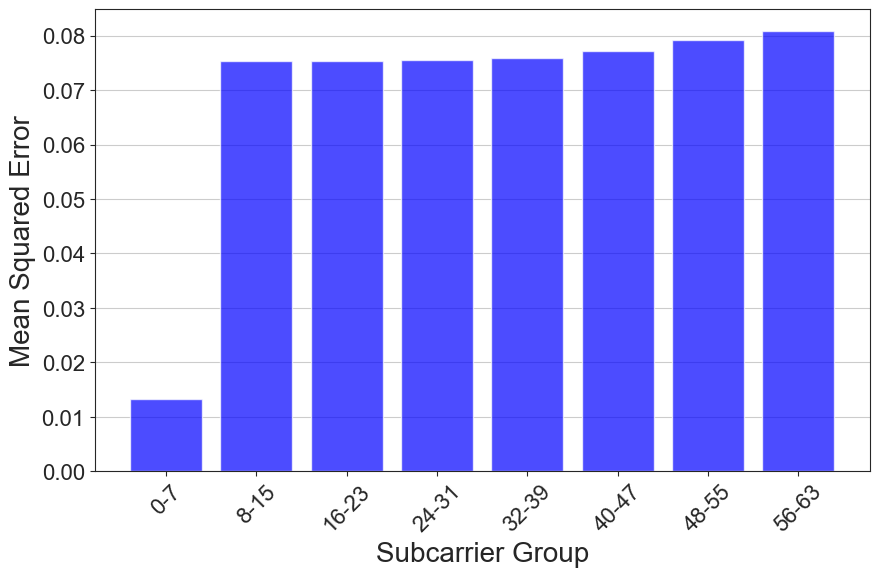

In [12]:
# Plot MSE for each subcarrier group
plt.figure(figsize=(10, 6))
plt.bar(subcarrier_df['Subcarrier Group'], subcarrier_df['MSE'], color='blue', alpha=0.7)
plt.xlabel("Subcarrier Group", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
# plt.title("Reconstruction MSE Across Subcarrier Groups")
plt.grid(axis='y')
plt.xticks(rotation=45)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/reconstruction_mse_across_subcarrier_groups.pdf", dpi=300, bbox_inches='tight')
plt.show()


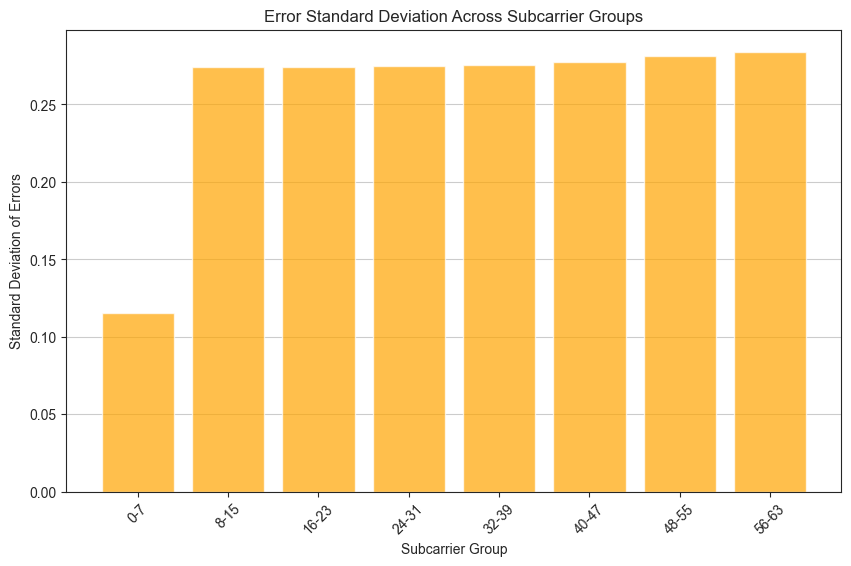

In [13]:
# Plot standard deviation of errors for each subcarrier group
plt.figure(figsize=(10, 6))
plt.bar(subcarrier_df['Subcarrier Group'], subcarrier_df['STD of Error'], color='orange', alpha=0.7)
plt.xlabel("Subcarrier Group")
plt.ylabel("Standard Deviation of Errors")
plt.title("Error Standard Deviation Across Subcarrier Groups")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


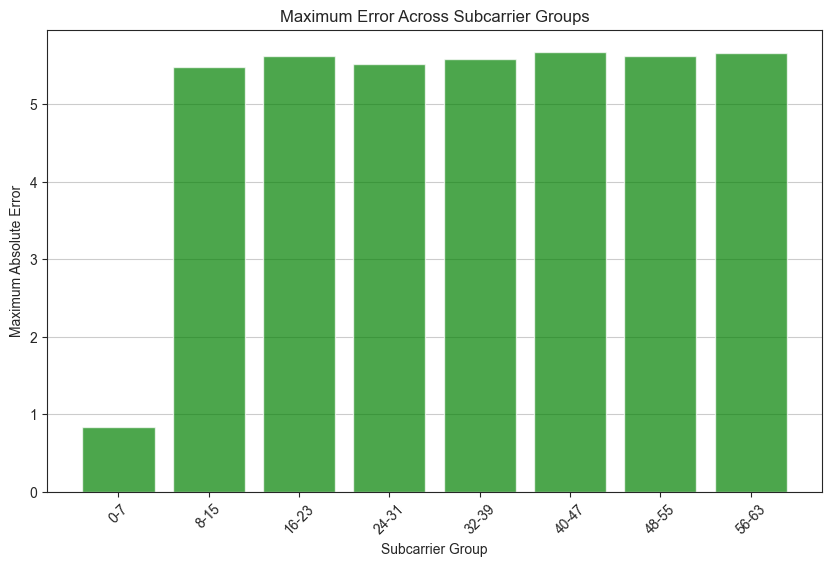

In [14]:
# Plot maximum error for each subcarrier group
plt.figure(figsize=(10, 6))
plt.bar(subcarrier_df['Subcarrier Group'], subcarrier_df['Max Error'], color='green', alpha=0.7)
plt.xlabel("Subcarrier Group")
plt.ylabel("Maximum Absolute Error")
plt.title("Maximum Error Across Subcarrier Groups")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


# Experiment 6 - Error Distribution Analysis

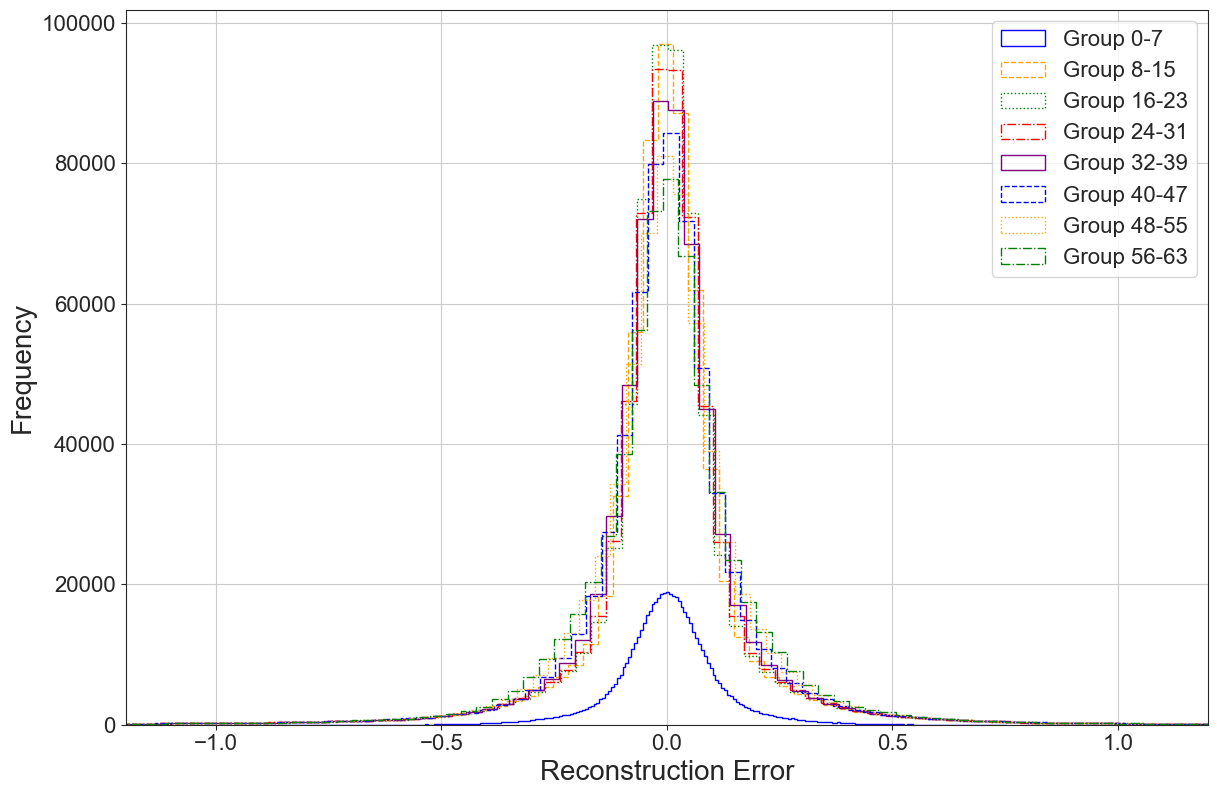

In [15]:
# Error Distribution Across All Subcarrier Groups
plt.figure(figsize=(12, 8))

linestyles = ['solid', 'dashed', 'dotted', 'dashdot']  # Define a variety of line styles
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define a variety of colors

for idx, group in enumerate(subcarrier_groups):  # Iterate over all subcarrier groups
    group_data = padded_data[:, group[0]:group[1] + 1, :]
    masked_group_data, _ = mask_data(group_data, mask_ratio=0.15)

    errors = []
    with torch.no_grad():
        # Move inputs and labels to the device
        inputs = torch.tensor(masked_group_data).float().to(device)
        labels = torch.tensor(group_data).float().to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute errors
        error = labels.cpu().numpy().flatten() - outputs.cpu().numpy().flatten()
        errors.extend(error)

    # Plot the error distribution for each subcarrier group with different styles
    plt.hist(
        errors,
        bins=250,
        histtype='step',
        linestyle=linestyles[idx % len(linestyles)],  # Cycle through linestyles
        color=colors[idx % len(colors)],  # Cycle through colors
        label=f"Group {group[0]}-{group[1]}"
    )

# Add labels and title
plt.xlabel("Reconstruction Error", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
# plt.title("Error Distribution Across All Subcarrier Groups")
plt.legend(loc='upper right', fontsize='small', prop={'size': 16})
plt.grid()
plt.tight_layout()
plt.xlim([-1.2, 1.2])

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

# Save the figure
plt.savefig("imgs/error_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()


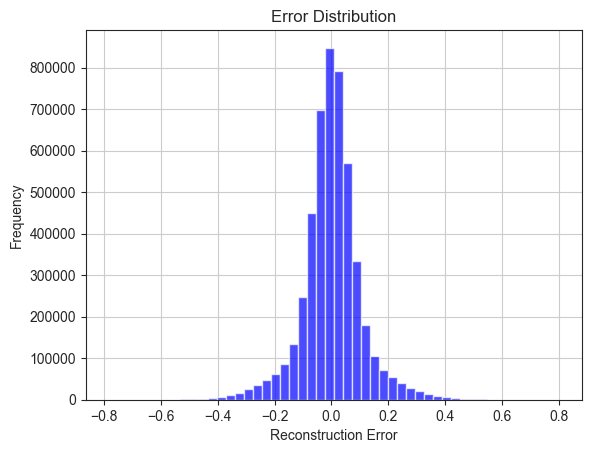

In [16]:
# Compute errors for all samples
errors = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        # Move tensors to CPU before converting to NumPy
        error = labels.cpu().numpy().flatten() - outputs.cpu().numpy().flatten()
        errors.extend(error)

# Plot error distribution
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.grid()
plt.show()


# Experiment 7 - Attention Mechanism Behavior

# Experiment 8 - Baseline Comparison

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Baseline models
linear_model = LinearRegression()
mlp_model = MLPRegressor(hidden_layer_sizes=(512,), max_iter=1000, random_state=42)

# Prepare training data
train_inputs = masked_data.reshape(-1, feature_dim)
train_labels = padded_data.reshape(-1, feature_dim)

# Train models
linear_model.fit(train_inputs, train_labels)
mlp_model.fit(train_inputs, train_labels)

# Evaluate models
baseline_mse = {
    'CSIBERT': avg_mse,
    'Linear Regression': mean_squared_error(train_labels, linear_model.predict(train_inputs)),
    'MLP': mean_squared_error(train_labels, mlp_model.predict(train_inputs))
}

# Create a table
baseline_df = pd.DataFrame({
    'Model': list(baseline_mse.keys()),
    'MSE': list(baseline_mse.values())
})
baseline_df

,Model,MSE
0,CSIBERT,0.010990
1,Linear Regression,0.080724
2,MLP,0.079655


# Experiment 9 - Impact of Doppler Shift

In [19]:
# Set up Seaborn for plotting
sns.set(style="whitegrid")

# Define Doppler shifts and initialize storage for results
doppler_shifts = np.linspace(50.0, 400.0, 32).round()  # Define 8 Doppler shifts
num_experiments = 100  # Number of experiments
results = []  # To store results across experiments

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform the experiment
for experiment in tqdm(range(num_experiments), desc="Experiments"):
    for doppler in doppler_shifts:
        # Add artificial noise to simulate Doppler effect
        noisy_data = padded_data + np.random.normal(0, doppler / 1000, padded_data.shape)

        # Ensure noisy_data is on the correct device
        with torch.no_grad():
            inputs = torch.tensor(noisy_data).float().to(device)  # Move to device
            labels = torch.tensor(padded_data).float().to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            
            # Move tensors back to CPU for evaluation
            mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())

        # Append results
        results.append({'Experiment': experiment + 1, 'Doppler Shift (Hz)': doppler, 'MSE': mse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Doppler Shift (Hz)',
    y='MSE',
    #hue='Experiment',
    errorbar='sd',  # Standard deviation as error bars
    err_style="band"
)
plt.xlabel("Doppler Shift (Hz)", fontsize=20)
plt.ylabel("Reconstruction MSE", fontsize=20)
#plt.title("Impact of Doppler Shift on Reconstruction MSE Across 10 Experiments")

sns.set_style("ticks")
# Enable gridlines explicitly using Matplotlib
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/impact_of_doppler_shift.pdf", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

Experiments:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Experiment 10 - Generalization Across Scenarios

   Train Scenario  Test Scenario       MSE
0               0              0  0.003184
1               0              1  0.003179
2               0              2  0.026606
3               1              0  0.003184
4               1              1  0.003179
5               1              2  0.026607
6               2              0  0.003184
7               2              1  0.003178
8               2              2  0.026606


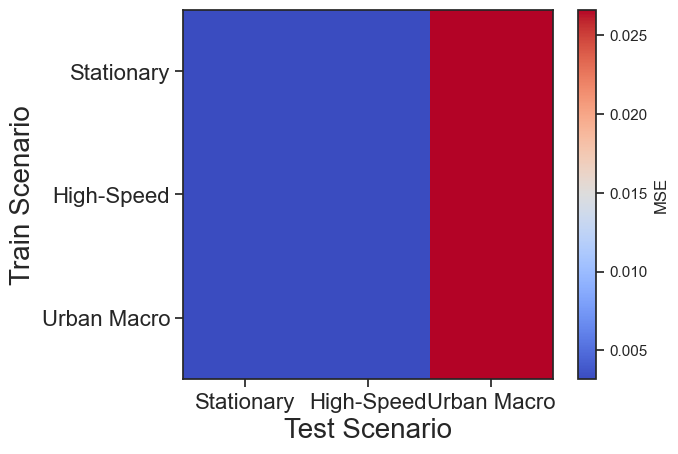

In [33]:
# Cross-scenario evaluation
cross_mse = []
for train_scenario_idx in range(3):  # Assuming 3 scenarios
    for test_scenario_idx in range(3):
        # Train on one scenario
        train_data = padded_data[train_scenario_idx::3]
        train_masked, _ = mask_data(train_data, mask_ratio=0.15)

        # Test on another scenario
        test_data = padded_data[test_scenario_idx::3]
        test_masked, _ = mask_data(test_data, mask_ratio=0.15)

        # Evaluate
        with torch.no_grad():
            inputs = torch.tensor(test_masked).float().to(device)
            labels = torch.tensor(test_data).float().to(device)
            outputs = model(inputs)
            mse = mean_squared_error(labels.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
            cross_mse.append((train_scenario_idx, test_scenario_idx, mse))

# Create a DataFrame
cross_df = pd.DataFrame(cross_mse, columns=['Train Scenario', 'Test Scenario', 'MSE'])
print(cross_df)

# Visualize
cross_pivot = cross_df.pivot(index='Train Scenario', columns='Test Scenario', values='MSE')
plt.imshow(cross_pivot.values, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="MSE")
# plt.title("Cross-Scenario Generalization")
plt.xlabel("Test Scenario", fontsize=20)
plt.ylabel("Train Scenario", fontsize=20)
plt.xticks(range(3), labels=['Stationary', 'High-Speed', 'Urban Macro'])  # Update labels as needed
plt.yticks(range(3), labels=['Stationary', 'High-Speed', 'Urban Macro'])  # Update labels as needed

# Increase x and y tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if any)

plt.savefig("imgs/generalization_across_scenarios.pdf", dpi=300, bbox_inches='tight')

plt.show()


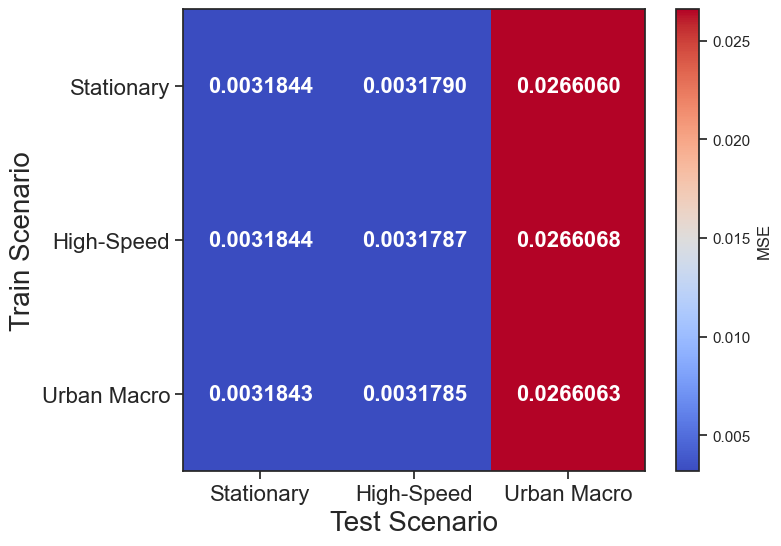

In [40]:
# Assuming cross_df is already created
# Pivot the data for visualization
cross_pivot = cross_df.pivot(index='Train Scenario', columns='Test Scenario', values='MSE')

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cross_pivot.values, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="MSE")

# Add values (annotations) to the heatmap with white and bold font
for i in range(cross_pivot.shape[0]):  # Rows
    for j in range(cross_pivot.shape[1]):  # Columns
        plt.text(
            j, i, f"{cross_pivot.values[i, j]:.7f}",  # Format to 7 decimal places
            ha='center', va='center', color='white', fontsize=16, fontweight='bold'
        )

# Add labels and title
plt.xlabel("Test Scenario", fontsize=20)
plt.ylabel("Train Scenario", fontsize=20)
plt.xticks(range(3), labels=['Stationary', 'High-Speed', 'Urban Macro'], fontsize=16)  # Update labels as needed
plt.yticks(range(3), labels=['Stationary', 'High-Speed', 'Urban Macro'], fontsize=16)  # Update labels as needed

# Save the plot
plt.savefig("imgs/generalization_across_scenarios.pdf", dpi=300, bbox_inches='tight')

plt.show()


## Revision 1 Comments

In [7]:
def compute_mse(model, data_loader, device):
    """
    Compute the mean squared error (MSE) of a model on a given DataLoader.
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())

    # Flatten all labels and predictions
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    return mean_squared_error(all_labels.flatten(), all_preds.flatten())

def measure_inference_time(model, sample_batch, device, num_iterations=50):
    """
    Measure the average inference time (in seconds) of a model over multiple iterations.
    """
    model.eval()
    # Warm-up pass
    with torch.no_grad():
        _ = model(sample_batch)

    start = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            outputs = model(sample_batch)
        # If using GPU, synchronize to ensure accurate timing
        if device.type == 'cuda':
            torch.cuda.synchronize()
    end = time.time()

    return (end - start) / num_iterations

def count_trainable_params(model):
    """
    Count the total number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def compare_models_performance_table(models, data_loader, device, num_iterations=50):
    """
    Compare multiple models' performance in terms of MSE, inference time (min), 
    and parameter count. Returns a pandas DataFrame.
    
    Args:
        models (dict): Dictionary where keys are model names (str) 
                       and values are the actual model instances.
        data_loader (DataLoader): DataLoader to compute MSE over.
        device (torch.device): Device on which to run the models.
        num_iterations (int): Number of iterations for inference time measurement.
    
    Returns:
        pd.DataFrame: Columns = ['Model', 'MSE', 'ExecutionTimeMin', 'NumParams']
    """
    # Take one batch from the DataLoader for inference timing
    sample_inputs, _ = next(iter(data_loader))
    sample_inputs = sample_inputs.to(device)

    results = []
    for model_name, model in models.items():
        # Compute MSE over the entire dataset
        mse_value = compute_mse(model, data_loader, device)
        
        # Measure average inference time (converted to minutes)
        avg_inference_sec = measure_inference_time(model, sample_inputs, device, num_iterations)
        avg_inference_min = avg_inference_sec / 60.0
        
        # Count parameters
        num_params = count_trainable_params(model)
        
        results.append({
            'Model': model_name,
            'MSE': mse_value,
            'ExecutionTimeMin': avg_inference_min,
            'NumParams': num_params
        })
    
    return pd.DataFrame(results)


## Small Model Experiments

In [10]:
# ---------------------------
# Load the original model (e.g., 12 layers)
checkpoint_path_big = "checkpoints/best_model.pt"
checkpoint_big = torch.load(checkpoint_path_big, map_location=device)
feature_dim = checkpoint_big["feature_dim"]

big_model = CSIBERT(feature_dim=feature_dim)
big_model.load_state_dict(checkpoint_big['model_state_dict'])
big_model.to(device)  # Move the model to the selected device
big_model.eval()
print("Original model loaded successfully.")

# ---------------------------
# Load the smaller model (6 layers)
checkpoint_path_small = "checkpoints/best_model-6layers.pt"
checkpoint_small = torch.load(checkpoint_path_small, map_location=device)
feature_dim_small = checkpoint_small["feature_dim"]

# Assume CSIBERT accepts a parameter 'num_hidden_layers' to control the number of layers.
small_model = CSIBERT(feature_dim=feature_dim_small, num_hidden_layers=6)
small_model.load_state_dict(checkpoint_small['model_state_dict'])
small_model.to(device)  # Move the model to the selected device
small_model.eval()
print("6-layer model loaded successfully.")


# Put them in a dictionary with meaningful names
model_dict = {
    "CSI-BERT (12 layers)": big_model,
    "CSI-BERT (6 layers)": small_model
}

# Then call the comparison method
df_results = compare_models_performance_table(model_dict, test_loader, device)
print(df_results)

Original model loaded successfully.
6-layer model loaded successfully.
                  Model       MSE  ExecutionTimeMin  NumParams
0  CSI-BERT (12 layers)  0.010981          0.002418  113808896
1   CSI-BERT (6 layers)  0.011002          0.001295   71281664


# Experiments for International Journal of Communication Systems
## Utilities + Models (CNN-1D & BiLSTM)

In [21]:
# --- Simple CNN & LSTM baselines: minimal setup and models ---
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# Ensure (N, T, F); if (N, F) given, treat T=1
def ensure_sequence(x):
    x = np.asarray(x)
    if x.ndim == 2:
        x = x[:, None, :]  # (N, 1, F)
    elif x.ndim != 3:
        raise ValueError(f"Expected 2D or 3D array, got {x.shape}")
    return x

class SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]

def train_epoch(model, loader, opt, crit):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = crit(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def predict_all(model, X_np, batch_size=512):
    model.eval()
    outs = []
    for i in range(0, X_np.shape[0], batch_size):
        xb = torch.from_numpy(X_np[i:i+batch_size]).float().to(device)
        outs.append(model(xb).cpu().numpy())
    return np.concatenate(outs, axis=0)

def fit_model(model, train_dataset, epochs=10, batch_size=128, lr=1e-3):
    model = model.to(device)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()
    for _ in tqdm(range(epochs), desc="Model training"):
        train_epoch(model, loader, opt, crit)
    return model

# --- Tiny CNN over time: 1 conv + 1x1 projection ---
class CNN1D(nn.Module):
    def __init__(self, f_in, hidden=64, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(f_in, hidden, kernel_size, padding=kernel_size//2)
        self.act  = nn.ReLU()
        self.proj = nn.Conv1d(hidden, f_in, kernel_size=1)  # 1x1 projection back to F
    def forward(self, x):              # x: (N, T, F)
        x = x.transpose(1, 2)          # (N, F, T)
        h = self.act(self.conv(x))     # (N, H, T)
        y = self.proj(h).transpose(1, 2)  # (N, T, F)
        return y

# --- Tiny LSTM: single layer, unidirectional ---
class LSTM(nn.Module):
    def __init__(self, f_in, hidden=64):
        super().__init__()
        self.rnn  = nn.LSTM(input_size=f_in, hidden_size=hidden, num_layers=1, batch_first=True)
        self.proj = nn.Linear(hidden, f_in)
    def forward(self, x):              # x: (N, T, F)
        h, _ = self.rnn(x)             # (N, T, H)
        return self.proj(h)            # (N, T, F)


In [25]:
# --- Train & evaluate tiny CNN/LSTM; append to baseline table ---
import pandas as pd
from sklearn.metrics import mean_squared_error

# Use your existing arrays; if needed, derive train inputs/labels
X_seq = ensure_sequence(masked_data)
Y_seq = ensure_sequence(padded_data)

N, T, F = X_seq.shape
assert F == feature_dim, f"feature_dim mismatch: F={F}, expected {feature_dim}"

train_ds = SeqDataset(X_seq, Y_seq)

# Train small models (fast & simple)
cnn_model  = fit_model(CNN1D(F, hidden=64, kernel_size=3), train_ds, epochs=20, batch_size=128, lr=1e-3)
lstm_model = fit_model(LSTM(F, hidden=64),                  train_ds, epochs=20, batch_size=128, lr=1e-3)

# Predict
cnn_pred  = predict_all(cnn_model,  X_seq)
lstm_pred = predict_all(lstm_model, X_seq)

# Compare with your existing metrics: flatten to (N·T, F)
y_true_flat   = Y_seq.reshape(-1, F)
cnn_pred_flat = cnn_pred.reshape(-1, F)
lstm_pred_flat= lstm_pred.reshape(-1, F)

cnn_mse  = mean_squared_error(y_true_flat, cnn_pred_flat)
lstm_mse = mean_squared_error(y_true_flat, lstm_pred_flat)

Model training:   0%|          | 0/20 [00:00<?, ?it/s]

Model training:   0%|          | 0/20 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'update'

In [32]:
# Extend baseline dict/table if they exist; otherwise create
try:
    baseline_mse
except NameError:
    baseline_mse = {}
baseline_mse.update({'Tiny CNN-1D': cnn_mse, 'Tiny LSTM': lstm_mse})

try:
    baseline_df
    extra = pd.DataFrame({'Model': ['Tiny CNN-1D', 'Tiny LSTM'], 'MSE': [cnn_mse, lstm_mse]})
    baseline_df = pd.concat([baseline_df, extra], ignore_index=True)
except NameError:
    baseline_df = pd.DataFrame({'Model': list(baseline_mse.keys()), 'MSE': list(baseline_mse.values())})

baseline_df = baseline_df.sort_values('MSE', ascending=True).reset_index(drop=True)
baseline_df

,Model,MSE
0,CSIBERT,0.010990
1,Tiny CNN-1D,0.015307
2,Tiny LSTM,0.021660
3,MLP,0.079655
4,Linear Regression,0.080724


## Experiments after 1st review

In [19]:
import time, os, torch
try:
    import psutil
except Exception:
    psutil = None

# ---- helpers ----

def infer_num_layers_from_state_dict(model_state_dict: dict, prefix="bert.encoder.layer."):
    """Infer number of encoder layers by scanning keys like 'bert.encoder.layer.{i}.'"""
    layer_ids = set()
    for k in model_state_dict.keys():
        if k.startswith(prefix):
            try:
                # e.g., "bert.encoder.layer.7.attention.self.query.weight"
                idx = int(k.split(prefix, 1)[1].split(".", 1)[0])
                layer_ids.add(idx)
            except Exception:
                pass
    return (max(layer_ids) + 1) if layer_ids else None

def count_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def _sync(devstr: str):
    if devstr == "cuda":
        torch.cuda.synchronize()
    # mps sync is typically implicit

def measure_memory_and_latency(
    model: torch.nn.Module,
    feature_dim: int,
    Ns: int,
    device_str: str,
    runs: int = 100,
    batch_size: int = 1,
):
    """Return (params, param_mem_mb, peak_mem_mb|None, avg_latency_ms)"""
    device = torch.device(device_str)
    model.to(device).eval()

    dummy = torch.randn(batch_size, Ns, feature_dim, device=device)

    params = count_parameters(model)
    param_mem_mb = params * 4 / (1024**2)  # fp32 baseline

    peak_mem_mb = None
    if device_str == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)

    proc = psutil.Process(os.getpid()) if psutil else None
    rss_before_mb = proc.memory_info().rss / (1024**2) if proc else None

    _sync(device_str)
    t0 = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _ = model(dummy)
    _sync(device_str)
    t1 = time.time()
    avg_latency_ms = (t1 - t0) * 1000.0 / runs

    if device_str == "cuda":
        peak_mem_mb = torch.cuda.max_memory_allocated(device) / (1024**2)
    elif device_str == "mps" and hasattr(torch, "mps"):
        try:
            current = torch.mps.current_allocated_memory()
            driver = torch.mps.driver_allocated_memory()
            peak_mem_mb = max(current, driver) / (1024**2)
        except Exception:
            peak_mem_mb = None
    else:
        if proc and rss_before_mb is not None:
            rss_after_mb = proc.memory_info().rss / (1024**2)
            peak_mem_mb = max(0.0, rss_after_mb - rss_before_mb)

    return params, param_mem_mb, peak_mem_mb, avg_latency_ms

def load_csibert_from_checkpoint(path: str, device):
    """Load CSIBERT with correct depth from a checkpoint."""
    ckpt = torch.load(path, map_location=device)
    feature_dim = ckpt["feature_dim"]

    # Prefer explicit config if stored; otherwise infer from state dict
    num_layers = ckpt.get("num_hidden_layers")
    if num_layers is None:
        num_layers = infer_num_layers_from_state_dict(ckpt["model_state_dict"]) or 12

    # If your CSIBERT ctor supports num_hidden_layers, pass it here
    model = CSIBERT(feature_dim=feature_dim, num_hidden_layers=num_layers)
    model.load_state_dict(ckpt["model_state_dict"], strict=True)

    Ns = ckpt.get("Ns", ckpt.get("num_subcarriers", 64))
    return model, feature_dim, Ns

# ---- device pick ----
if torch.cuda.is_available():
    device_str = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device_str = "mps"
else:
    device_str = "cpu"
device = torch.device(device_str)

# ---- load 12-layer ----
model_12, feature_dim_12, Ns_12 = load_csibert_from_checkpoint(
    "checkpoints/best_model-12-layers.pt", device
)
p12, pm12, peak12, lat12 = measure_memory_and_latency(
    model_12, feature_dim_12, Ns_12, device_str=device_str, runs=100, batch_size=1
)
print(f"[12-layer] Params: {p12:,} | Param mem: {pm12:.2f} MB | "
      f"Peak inf mem: {('N/A' if peak12 is None else f'{peak12:.2f} MB')} | "
      f"Latency: {lat12:.3f} ms/frame on {device_str.upper()}")

# ---- load 6-layer ----
model_6, feature_dim_6, Ns_6 = load_csibert_from_checkpoint(
    "checkpoints/best_model-6-layers.pt", device
)
p6, pm6, peak6, lat6 = measure_memory_and_latency(
    model_6, feature_dim_6, Ns_6, device_str=device_str, runs=100, batch_size=1
)
print(f"[6-layer ] Params: {p6:,} | Param mem: {pm6:.2f} MB | "
      f"Peak inf mem: {('N/A' if peak6 is None else f'{peak6:.2f} MB')} | "
      f"Latency: {lat6:.3f} ms/frame on {device_str.upper()}")


[12-layer] Params: 113,808,896 | Param mem: 434.15 MB | Peak inf mem: 4834.66 MB | Latency: 21.276 ms/frame on MPS
[6-layer ] Params: 71,281,664 | Param mem: 271.92 MB | Peak inf mem: 4834.66 MB | Latency: 12.109 ms/frame on MPS


In [20]:
import time
import math
import torch
import statistics as stats

# ---------- Device helpers ----------
def _sync(devstr: str):
    if devstr == "cuda":
        torch.cuda.synchronize()
    # MPS: synchronization is implicit in most ops; no explicit API required.

def pick_device_str():
    if torch.cuda.is_available():
        return "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

# ---------- Latency measurement ----------
@torch.inference_mode()
def measure_latency_stats(
    model: torch.nn.Module,
    feature_dim: int,
    Ns: int,
    device_str: str,
    batch_size: int = 1,
    warmup: int = 10,
    runs: int = 100,
    use_amp: bool = False,
):
    """
    Returns a dict with latency stats in ms:
      mean, std, p50, p90, p99, throughput_fps (for the given batch size)
    Measures per-forward latency (for 'batch_size' samples).
    """
    device = torch.device(device_str)
    model = model.to(device).eval()

    # Optional input autocast (useful for CUDA fp16/bf16); MPS supports fp16 under the hood.
    scaler_ctx = torch.autocast(device_type=device_str, enabled=use_amp, dtype=torch.float16) if device_str != "cpu" else torch.autocast(device_type="cpu", enabled=False)

    # pre-allocate dummy input to avoid realloc during timing
    x = torch.randn(batch_size, Ns, feature_dim, device=device)

    # Optional CUDA perf hint
    if device_str == "cuda":
        torch.backends.cudnn.benchmark = True  # helpful for convs; harmless otherwise

    # Warmup
    for _ in range(warmup):
        with scaler_ctx:
            _ = model(x)
    _sync(device_str)

    # Timed runs (per-iteration sync so timings are accurate)
    times = []
    for _ in range(runs):
        t0 = time.perf_counter()
        with scaler_ctx:
            _ = model(x)
        _sync(device_str)
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000.0)  # ms

    mean_ms = sum(times) / len(times)
    std_ms = math.sqrt(sum((t - mean_ms) ** 2 for t in times) / (len(times) - 1)) if len(times) > 1 else 0.0
    p50 = stats.median(times)
    p90 = stats.quantiles(times, n=10)[8] if len(times) >= 10 else max(times)
    # p99 robust estimate
    times_sorted = sorted(times)
    idx_99 = max(0, int(round(0.99 * (len(times_sorted) - 1))))
    p99 = times_sorted[idx_99]

    # Throughput in frames/sec for this batch size
    throughput_fps = (batch_size * 1000.0) / mean_ms

    return {
        "mean_ms": mean_ms,
        "std_ms": std_ms,
        "p50_ms": p50,
        "p90_ms": p90,
        "p99_ms": p99,
        "throughput_fps": throughput_fps,
        "batch_size": batch_size,
        "Ns": Ns,
        "amp": use_amp,
    }

# ---------- Example usage ----------
device_str = pick_device_str()

# You already loaded these:
# model_12, feature_dim_12, Ns_12
# model_6,  feature_dim_6,  Ns_6

# 1) Real-time: per-frame latency (batch_size = 1)
lat12_b1 = measure_latency_stats(model_12, feature_dim_12, Ns_12, device_str, batch_size=1, warmup=15, runs=200, use_amp=True)
lat6_b1  = measure_latency_stats(model_6,  feature_dim_6,  Ns_6,  device_str, batch_size=1, warmup=15, runs=200, use_amp=True)

print(f"[12-layer | b=1] mean={lat12_b1['mean_ms']:.3f} ms, p50={lat12_b1['p50_ms']:.3f}, "
      f"p90={lat12_b1['p90_ms']:.3f}, p99={lat12_b1['p99_ms']:.3f}, "
      f"std={lat12_b1['std_ms']:.3f}, fps≈{lat12_b1['throughput_fps']:.1f} (AMP={lat12_b1['amp']})")

print(f"[ 6-layer | b=1] mean={lat6_b1['mean_ms']:.3f} ms, p50={lat6_b1['p50_ms']:.3f}, "
      f"p90={lat6_b1['p90_ms']:.3f}, p99={lat6_b1['p99_ms']:.3f}, "
      f"std={lat6_b1['std_ms']:.3f}, fps≈{lat6_b1['throughput_fps']:.1f} (AMP={lat6_b1['amp']})")

# 2) Throughput mode: larger batch sizes (optional)
for b in [2, 4, 8]:
    res = measure_latency_stats(model_12, feature_dim_12, Ns_12, device_str, batch_size=b, warmup=10, runs=100, use_amp=True)
    print(f"[12-layer | b={b}] mean={res['mean_ms']:.2f} ms  | fps≈{res['throughput_fps']:.1f}")

# 3) Scalability with Ns (optional): show how latency grows with sequence length
for Ns_test in [32, 64, 128]:
    res = measure_latency_stats(model_6, feature_dim_6, Ns_test, device_str, batch_size=1, warmup=10, runs=150, use_amp=True)
    print(f"[6-layer | Ns={Ns_test}] mean={res['mean_ms']:.3f} ms, p90={res['p90_ms']:.3f}, fps≈{res['throughput_fps']:.1f}")


[12-layer | b=1] mean=13.302 ms, p50=13.221, p90=14.251, p99=16.083, std=0.790, fps≈75.2 (AMP=True)
[ 6-layer | b=1] mean=7.286 ms, p50=7.216, p90=7.922, p99=8.867, std=0.490, fps≈137.3 (AMP=True)
[12-layer | b=2] mean=29.99 ms  | fps≈66.7
[12-layer | b=4] mean=50.18 ms  | fps≈79.7
[12-layer | b=8] mean=77.76 ms  | fps≈102.9
[6-layer | Ns=32] mean=17.806 ms, p90=23.659, fps≈56.2
[6-layer | Ns=64] mean=19.543 ms, p90=25.337, fps≈51.2
[6-layer | Ns=128] mean=22.104 ms, p90=26.777, fps≈45.2
